## **Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
import warnings
import pickle


## **Downloading Dataset**

In [ ]:
import kagglehub
import os
import pandas as pd

path = kagglehub.dataset_download("rupakroy/online-payments-fraud-detection-dataset")

df = pd.read_csv(os.path.join(path, "PS_20174392719_1491204439457_log.csv"))
#df_sample = df.sample(frac=0.70, random_state=42).sort_index() # Sample 70% of the data
# and sort by index. 70% sample used due to RAM limitation.

df_sample = df # Use the entire dataset
df_sample

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


## **Visualizing & Analyzing Data**

In [ ]:
df_sample.columns  # Column Names

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [ ]:
df_sample.drop(['isFlaggedFraud'], axis = 1, inplace = True )
# Dropping column which isn't needed and doesn't affect model accuracy

# Feature Engineering
df_sample['nameOrig_count'] = df_sample.groupby('nameOrig')['nameOrig'].transform('count')
df_sample['nameDest_count'] = df_sample.groupby('nameDest')['nameDest'].transform('count')
df_sample['nameOrig_mean_amount'] = df_sample.groupby('nameOrig')['amount'].transform('mean')
df_sample['nameDest_mean_amount'] = df_sample.groupby('nameDest')['amount'].transform('mean')
df_sample['nameOrig_max_amount'] = df_sample.groupby('nameOrig')['amount'].transform('max')
df_sample['nameDest_max_amount'] = df_sample.groupby('nameDest')['amount'].transform('max')
df_sample['nameOrig_std_amount'] = df_sample.groupby('nameOrig')['amount'].transform('std').fillna(0)
df_sample['nameDest_std_amount'] = df_sample.groupby('nameDest')['amount'].transform('std').fillna(0)

df_sample

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,nameOrig_count,nameDest_count,nameOrig_mean_amount,nameDest_mean_amount,nameOrig_max_amount,nameDest_max_amount,nameOrig_std_amount,nameDest_std_amount
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,1,1,9839.64,9.839640e+03,9839.64,9839.64,0.0,0.000000e+00
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,1,1,1864.28,1.864280e+03,1864.28,1864.28,0.0,0.000000e+00
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,1,44,181.00,2.255178e+05,181.00,1447322.21,0.0,2.526558e+05
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,1,41,181.00,4.394442e+05,181.00,4399755.69,0.0,8.789905e+05
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,1,1,11668.14,1.166814e+04,11668.14,11668.14,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,1,2,339682.13,3.323914e+05,339682.13,339682.13,0.0,1.031071e+04
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,1,1,6311409.28,6.311409e+06,6311409.28,6311409.28,0.0,0.000000e+00
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,1,3,6311409.28,2.212471e+06,6311409.28,6311409.28,0.0,3.551043e+06
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,1,1,850002.52,8.500025e+05,850002.52,850002.52,0.0,0.000000e+00


In [ ]:
df_sample.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,nameOrig_count,nameDest_count,nameOrig_mean_amount,nameDest_mean_amount,nameOrig_max_amount,nameDest_max_amount,nameOrig_std_amount,nameDest_std_amount
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,1,1,9839.64,9839.640000,9839.64,9839.64,0.0,0.000000
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,1,1,1864.28,1864.280000,1864.28,1864.28,0.0,0.000000
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,1,44,181.00,225517.832045,181.00,1447322.21,0.0,252655.757617
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,1,41,181.00,439444.208049,181.00,4399755.69,0.0,878990.484226
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,1,1,11668.14,11668.140000,11668.14,11668.14,0.0,0.000000


In [ ]:
df_sample.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,nameOrig_count,nameDest_count,nameOrig_mean_amount,nameDest_mean_amount,nameOrig_max_amount,nameDest_max_amount,nameOrig_std_amount,nameDest_std_amount
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,1,2,339682.13,3.323914e+05,339682.13,339682.13,0.0,1.031071e+04
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,1,1,6311409.28,6.311409e+06,6311409.28,6311409.28,0.0,0.000000e+00
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,1,3,6311409.28,2.212471e+06,6311409.28,6311409.28,0.0,3.551043e+06
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,1,1,850002.52,8.500025e+05,850002.52,850002.52,0.0,0.000000e+00
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,1,28,850002.52,3.196506e+05,850002.52,1287118.98,0.0,2.816269e+05


In [ ]:
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [ ]:
df_sample.corr(numeric_only=True)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,nameOrig_count,nameDest_count,nameOrig_mean_amount,nameDest_mean_amount,nameOrig_max_amount,nameDest_max_amount,nameOrig_std_amount,nameDest_std_amount
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,-0.000830,-0.336167,0.022365,-0.007536,0.022336,-0.100946,0.000810,-0.046593
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.000292,0.158413,0.999006,0.485990,0.998018,0.375741,0.042374,0.432890
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,-0.000340,0.142752,-0.002759,0.075658,-0.002786,0.056355,-0.000785,0.052538
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,-0.000343,0.145336,-0.007858,0.071670,-0.007876,0.055643,-0.000901,0.051847
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,0.000351,0.378800,0.293774,0.611578,0.293549,0.659056,0.013923,0.667385
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,0.000430,0.375987,0.458776,0.661121,0.458393,0.684858,0.021052,0.705368
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.000316,-0.008982,0.076671,0.079746,0.076525,0.017676,0.001675,0.017348
nameOrig_count,-0.000830,0.000292,-0.000340,-0.000343,0.000351,0.000430,0.000316,1.000000,0.000181,0.000292,0.000051,0.011748,0.000238,0.256891,0.000080
nameDest_count,-0.336167,0.158413,0.142752,0.145336,0.378800,0.375987,-0.008982,0.000181,1.000000,0.158301,0.325959,0.157998,0.434912,0.003423,0.320915
nameOrig_mean_amount,0.022365,0.999006,-0.002759,-0.007858,0.293774,0.458776,0.076671,0.000292,0.158301,1.000000,0.485512,0.999011,0.375289,0.042417,0.432442


Heatmap

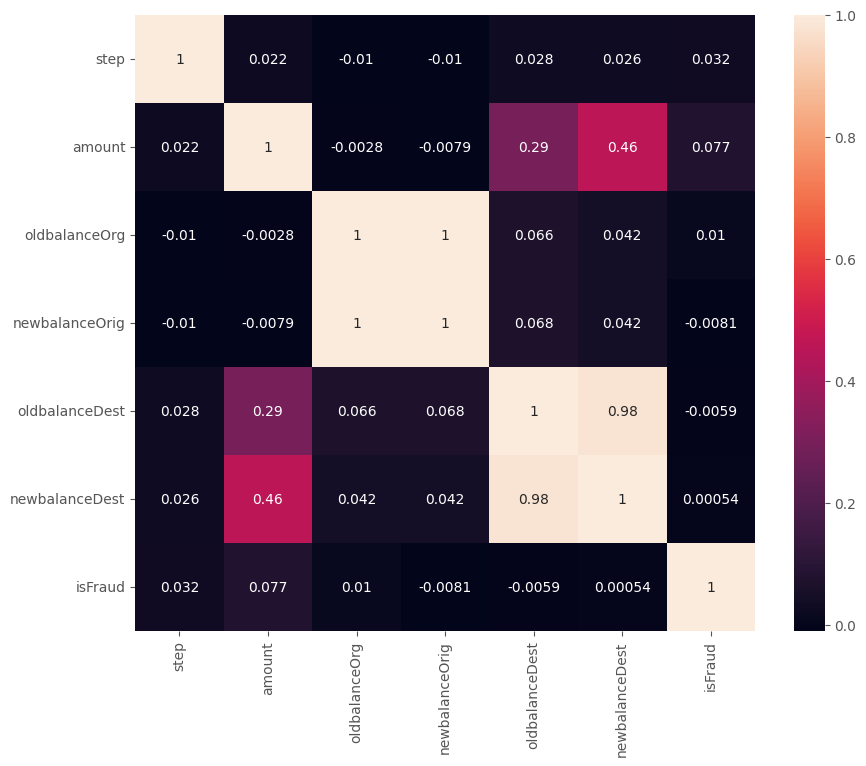

In [ ]:
columns_for_heatmap = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']
plt.figure(figsize=(10, 8))
sns.heatmap(df_sample[columns_for_heatmap].corr(numeric_only=True), annot=True)
plt.show()

### **Univariate Analysis**

Univariate Histogram (Step Column)

<Axes: xlabel='step', ylabel='Count'>

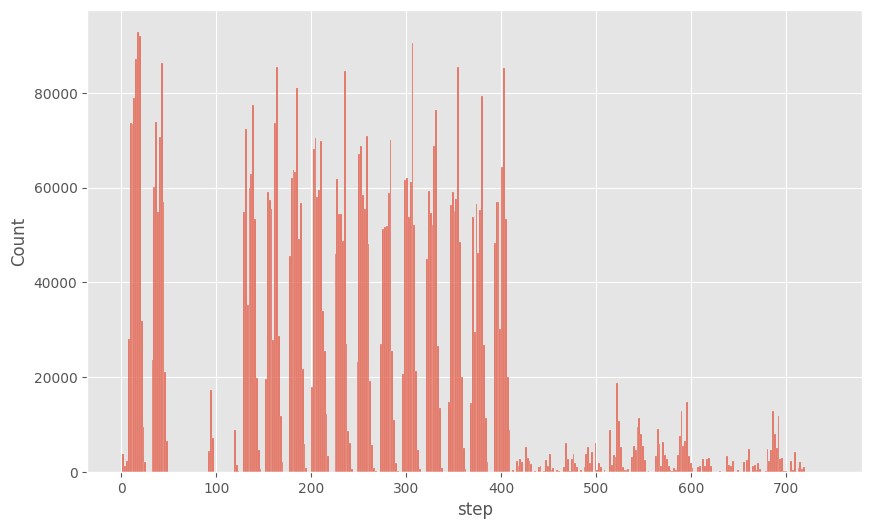

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data= df_sample, x = 'step')

Box plot (Step Column)

<Axes: xlabel='step'>

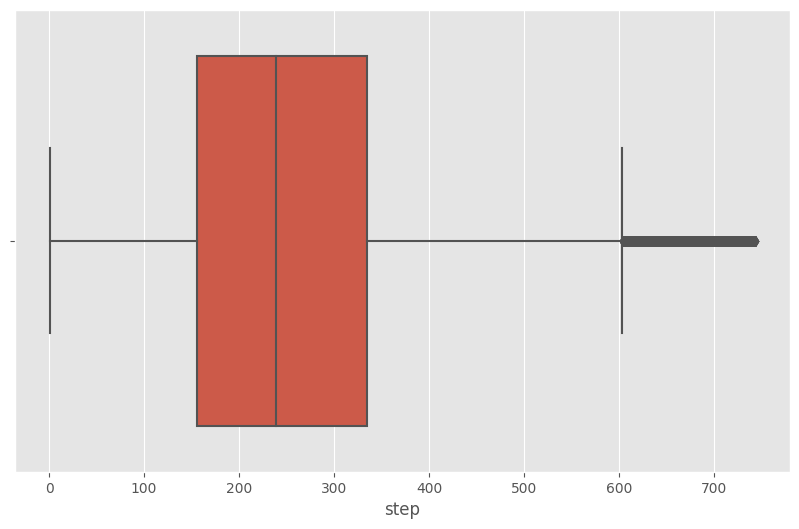

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data = df_sample, x='step')

Count plot (Type Column)

<Axes: xlabel='type', ylabel='count'>

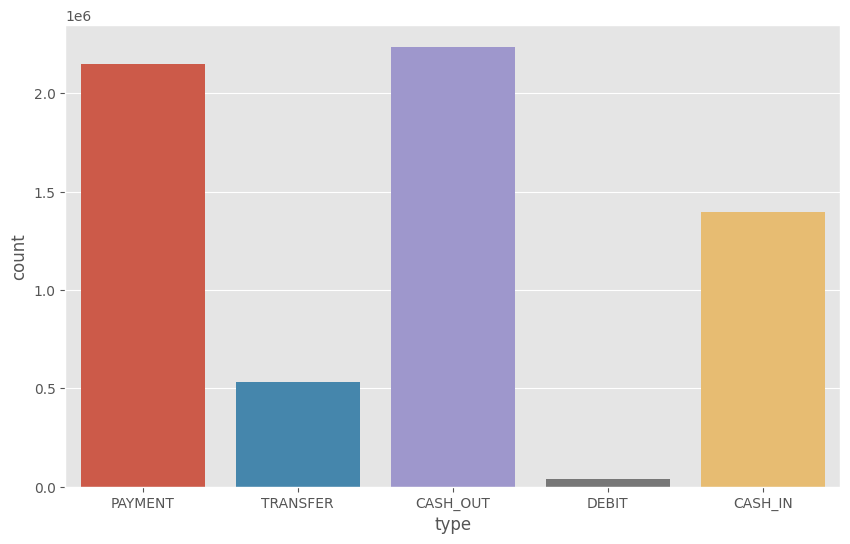

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data = df_sample , x = 'type' )

Univariate Histogram (Amount Column)

<Axes: xlabel='amount', ylabel='Count'>

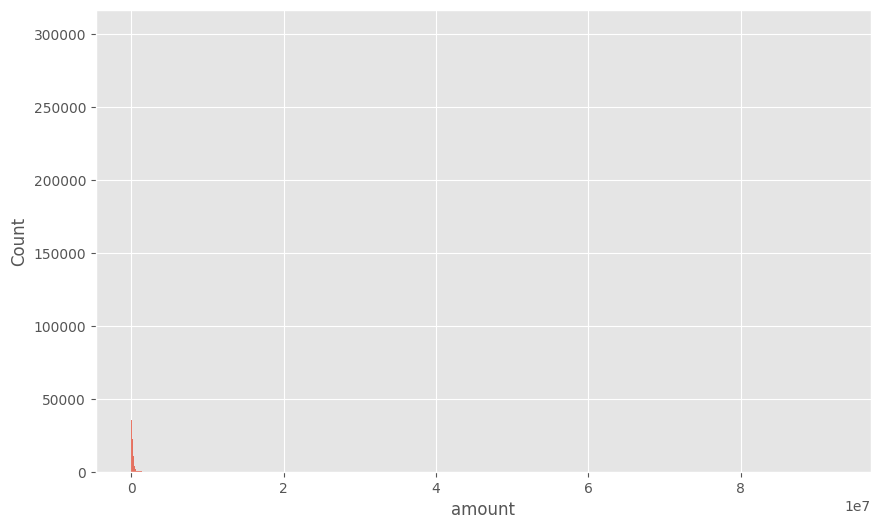

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data = df_sample, x ='amount')

Box plot (Amount Column)

<Axes: xlabel='amount'>

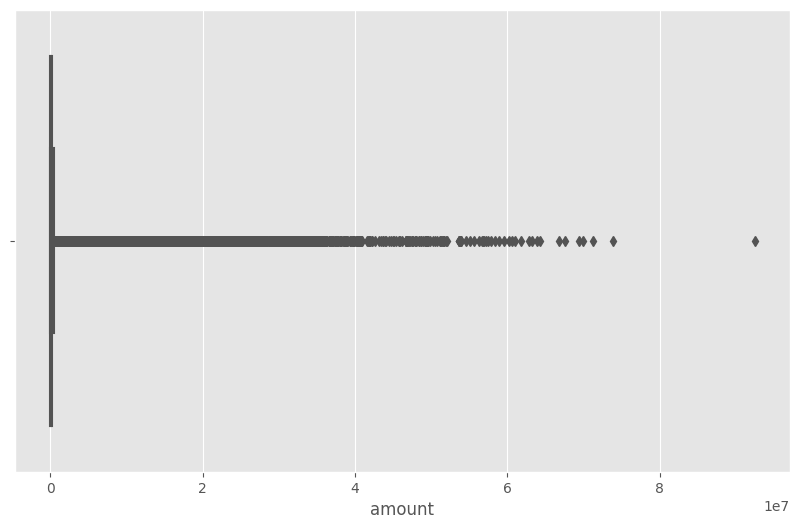

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data = df_sample, x = 'amount')

Univariate Histogram (oldbalanceOrg Column)

<Axes: xlabel='oldbalanceOrg', ylabel='Count'>

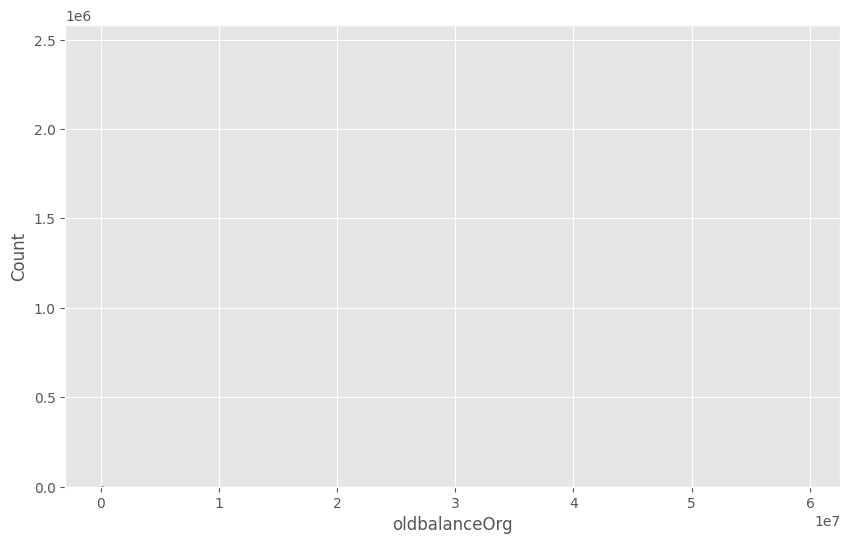

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data = df_sample, x = 'oldbalanceOrg')

In [ ]:
df_sample['nameDest'].value_counts()

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
              ... 
M1470027725      1
M1330329251      1
M1784358659      1
M2081431099      1
C2080388513      1
Name: count, Length: 2722362, dtype: int64

Box plot (oldbalanceOrg Column)

<Axes: xlabel='oldbalanceOrg'>

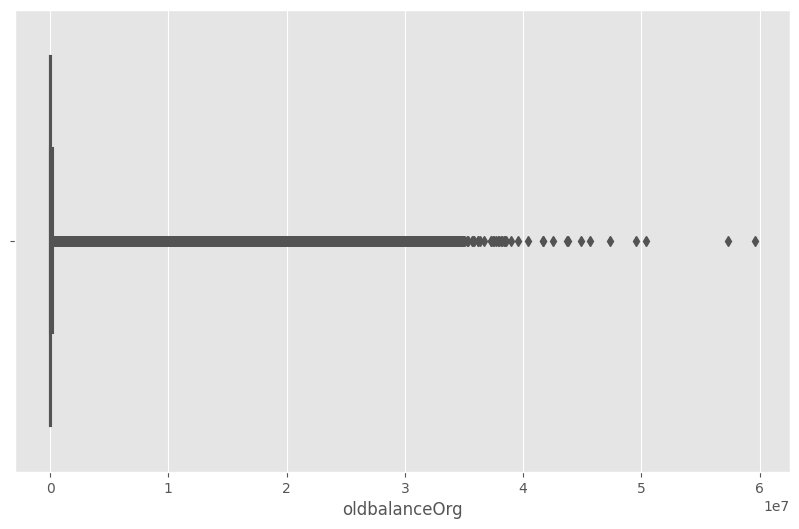

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data = df_sample, x = 'oldbalanceOrg')

Box plot (newbalanceDest Column)

<Axes: xlabel='newbalanceDest'>

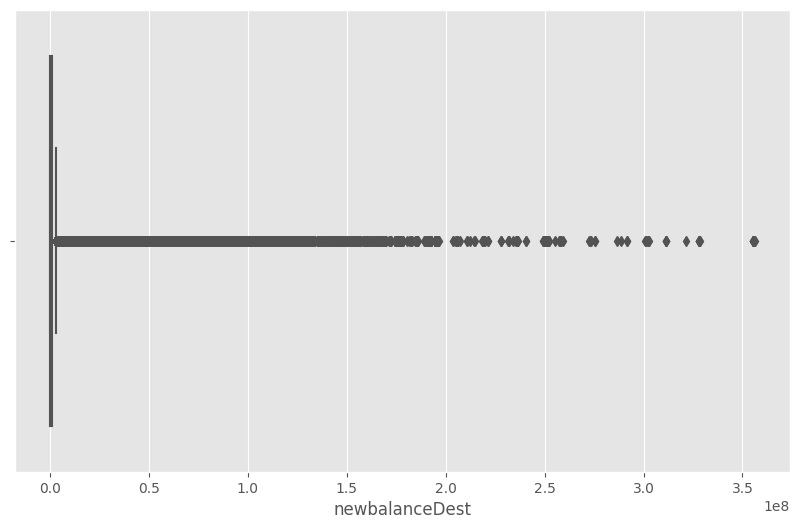

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data = df_sample, x = 'newbalanceDest')

Count plot (isFraud Column)

<Axes: xlabel='isFraud', ylabel='count'>

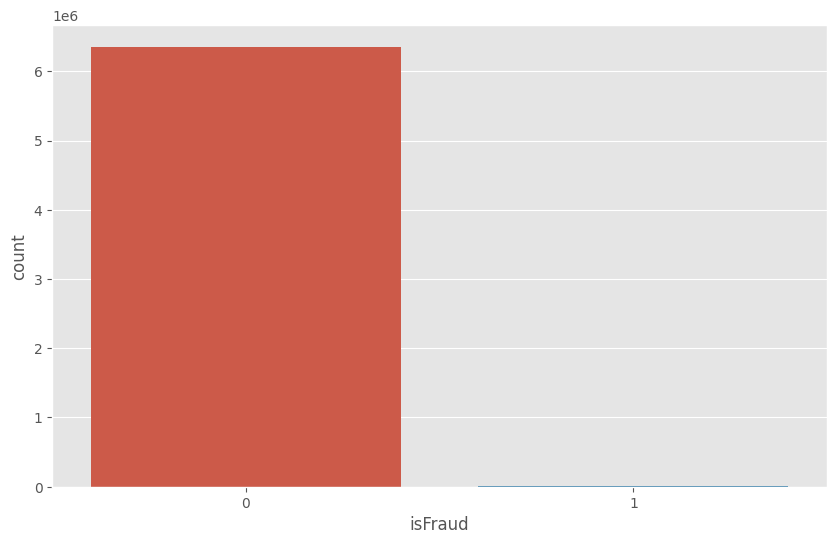

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data = df_sample, x = 'isFraud')

In [ ]:
df_sample['isFraud'].value_counts()
#Fraud transactions very low compared to Normal transactions
#Model will be near ideal

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [ ]:
df_sample['isFraud'] = df_sample['isFraud'].astype(str)
df_sample.loc[df_sample['isFraud'] == '0', 'isFraud'] = 'is not Fraud'
df_sample.loc[df_sample['isFraud'] == '1', 'isFraud'] = 'is Fraud'

In [ ]:
df_sample

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,nameOrig_count,nameDest_count,nameOrig_mean_amount,nameDest_mean_amount,nameOrig_max_amount,nameDest_max_amount,nameOrig_std_amount,nameDest_std_amount
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,is not Fraud,1,1,9839.64,9.839640e+03,9839.64,9839.64,0.0,0.000000e+00
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,is not Fraud,1,1,1864.28,1.864280e+03,1864.28,1864.28,0.0,0.000000e+00
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,is Fraud,1,44,181.00,2.255178e+05,181.00,1447322.21,0.0,2.526558e+05
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,is Fraud,1,41,181.00,4.394442e+05,181.00,4399755.69,0.0,8.789905e+05
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,is not Fraud,1,1,11668.14,1.166814e+04,11668.14,11668.14,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,is Fraud,1,2,339682.13,3.323914e+05,339682.13,339682.13,0.0,1.031071e+04
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,is Fraud,1,1,6311409.28,6.311409e+06,6311409.28,6311409.28,0.0,0.000000e+00
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,is Fraud,1,3,6311409.28,2.212471e+06,6311409.28,6311409.28,0.0,3.551043e+06
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,is Fraud,1,1,850002.52,8.500025e+05,850002.52,850002.52,0.0,0.000000e+00


### **Bivariate Analysis**

Joint plot

<Figure size 1000x800 with 0 Axes>

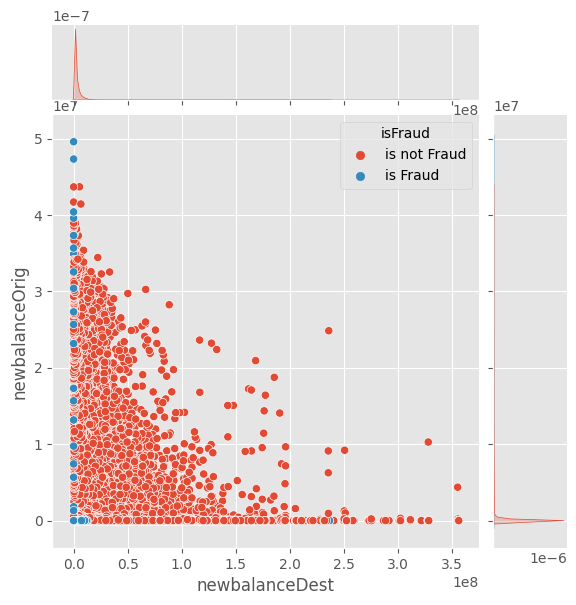

In [ ]:
plt.figure(figsize=(10, 8))
sns.jointplot(data = df_sample, x='newbalanceDest', y='newbalanceOrig', hue='isFraud')

Count plot (type column)

<Axes: xlabel='type', ylabel='count'>

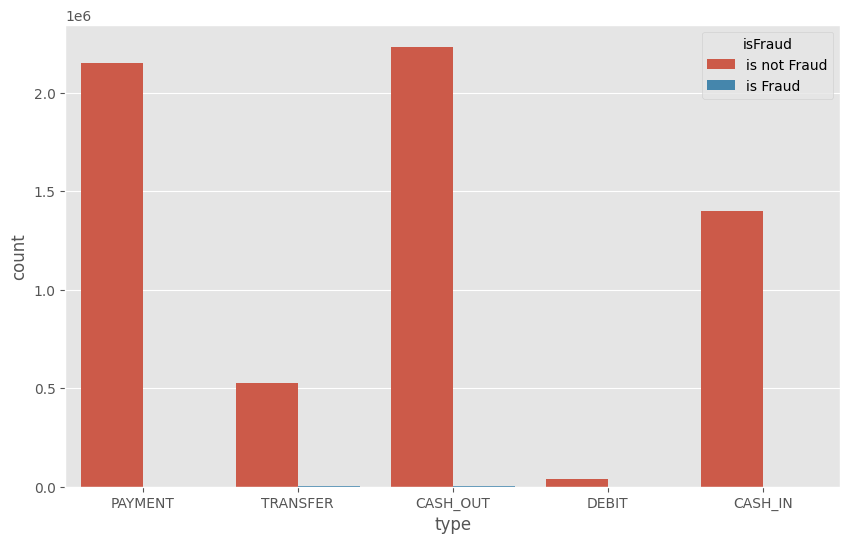

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data = df_sample,x='type', hue ='isFraud' )

Box plot (step & isFraud Column)

<Axes: xlabel='isFraud', ylabel='step'>

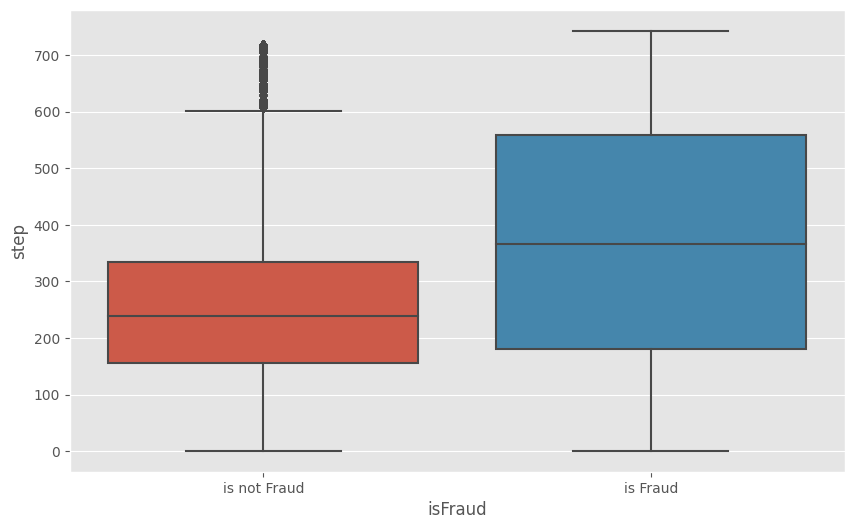

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data = df_sample, x= 'isFraud', y ='step')

Box plot (isFraud & amount Column)

<Axes: xlabel='isFraud', ylabel='amount'>

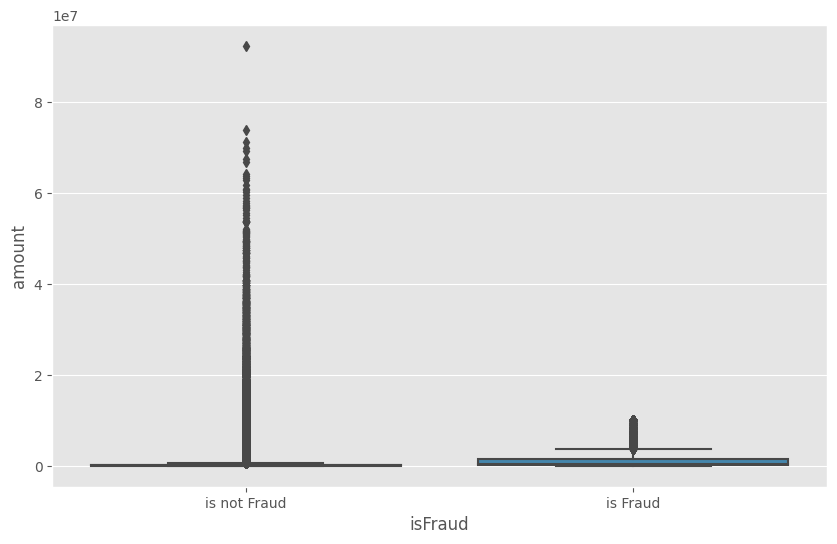

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data = df_sample, x='isFraud', y= 'amount')

Box plot (isFraud & oldbalanceOrg Column)

<Axes: xlabel='isFraud', ylabel='oldbalanceOrg'>

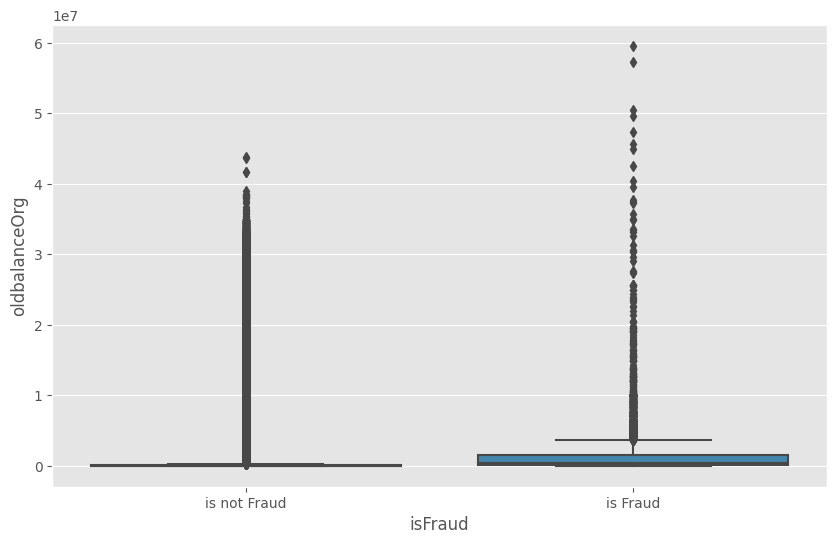

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data = df_sample, x='isFraud', y= 'oldbalanceOrg')

Box plot (isFraud & newbalanceOrig Column)

<Axes: xlabel='isFraud', ylabel='newbalanceOrig'>

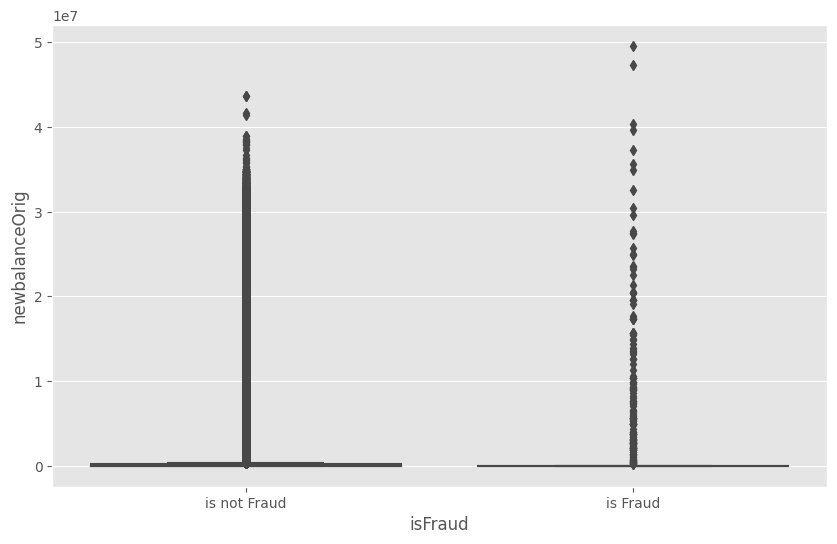

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data = df_sample, x = 'isFraud', y= 'newbalanceOrig')

Violin plot (isFraud & oldbalanceDest Column)

<Axes: xlabel='isFraud', ylabel='oldbalanceDest'>

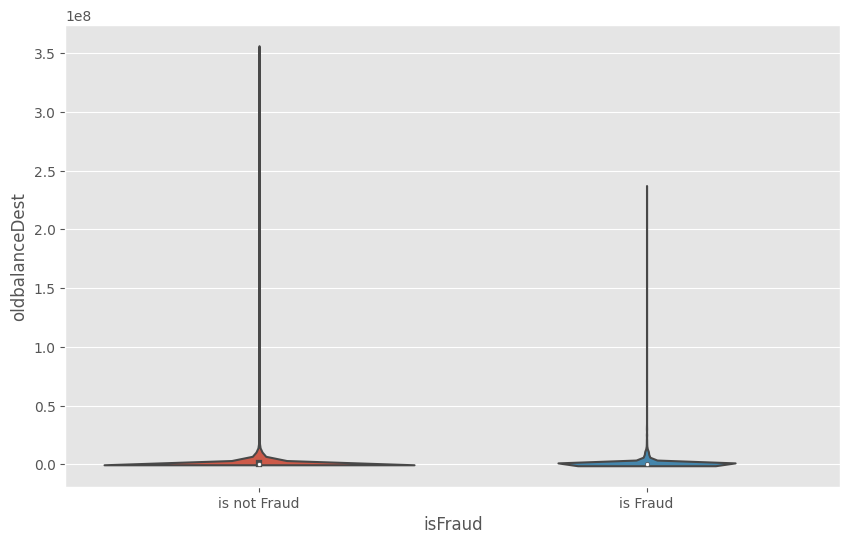

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(data = df_sample, x = 'isFraud', y = 'oldbalanceDest' )

## **Descriptive Analysis**

In [ ]:
#df_sample = df.sample(frac=0.70, random_state=42) # Sample 70% of the data
df_sample = df.sample(frac=1.0, random_state=42) # Sample 100% of the data

In [ ]:
df_sample.describe(include = 'all')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,nameOrig_count,nameDest_count,nameOrig_mean_amount,nameDest_mean_amount,nameOrig_max_amount,nameDest_max_amount,nameOrig_std_amount,nameDest_std_amount
count,6.362620e+06,6362620,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
unique,NaN,5,NaN,6353307,NaN,NaN,2722362,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,CASH_OUT,NaN,C1530544995,NaN,NaN,C1286084959,NaN,NaN,is not Fraud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,2237500,NaN,3,NaN,NaN,113,NaN,NaN,6354407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.433972e+02,NaN,1.798619e+05,NaN,8.338831e+05,8.551137e+05,NaN,1.100702e+06,1.224996e+06,NaN,1.002932e+00,1.119224e+01,1.798619e+05,1.798619e+05,1.802373e+05,8.092213e+05,5.301251e+02,2.029178e+05
std,1.423320e+02,NaN,6.038582e+05,NaN,2.888243e+06,2.924049e+06,NaN,3.399180e+06,3.674129e+06,NaN,5.420031e-02,1.239544e+01,6.032581e+05,2.934691e+05,6.049980e+05,2.030868e+06,3.805561e+04,5.116111e+05
min,1.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,NaN,1.338957e+04,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,1.000000e+00,1.000000e+00,1.342510e+04,1.680838e+04,1.343377e+04,1.685676e+04,0.000000e+00,0.000000e+00
50%,2.390000e+02,NaN,7.487194e+04,NaN,1.420800e+04,0.000000e+00,NaN,1.327057e+05,2.146614e+05,NaN,1.000000e+00,7.000000e+00,7.506466e+04,1.583857e+05,7.521228e+04,3.459873e+05,0.000000e+00,1.086862e+05
75%,3.350000e+02,NaN,2.087215e+05,NaN,1.073152e+05,1.442584e+05,NaN,9.430367e+05,1.111909e+06,NaN,1.000000e+00,1.700000e+01,2.086761e+05,2.449600e+05,2.091068e+05,8.279908e+05,0.000000e+00,2.181031e+05


## **Data Preprocessing**

### **Checking for Null Values**

In [ ]:
df_sample.isnull().sum()

step                    0
type                    0
amount                  0
nameOrig                0
oldbalanceOrg           0
newbalanceOrig          0
nameDest                0
oldbalanceDest          0
newbalanceDest          0
isFraud                 0
nameOrig_count          0
nameDest_count          0
nameOrig_mean_amount    0
nameDest_mean_amount    0
nameOrig_max_amount     0
nameDest_max_amount     0
nameOrig_std_amount     0
nameDest_std_amount     0
dtype: int64

In [ ]:
df_sample.info

<bound method DataFrame.info of          step      type      amount     nameOrig  oldbalanceOrg  \
3737323   278   CASH_IN   330218.42   C632336343       20866.00   
264914     15   PAYMENT    11647.08  C1264712553       30370.00   
85647      10   CASH_IN   152264.21  C1746846248      106589.00   
5899326   403  TRANSFER  1551760.63   C333676753           0.00   
2544263   206   CASH_IN    78172.30   C813403091     2921331.58   
...       ...       ...         ...          ...            ...   
1570006   155   CASH_IN   129715.85   C170740978     5054252.83   
2234489   186   PAYMENT     2459.70  C1844108072           0.00   
4926484   350  CASH_OUT    10579.16  C1579684659       59279.00   
4304572   307  CASH_OUT    73020.76   C379222646       20289.00   
1692743   159  CASH_OUT    89698.85   C964068732      196071.00   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  \
3737323       351084.42   C834976624       452419.57       122201.15   
264914         1872

### **Handling Outliers**

Box plot (amount Column as y-axis)

<Axes: >

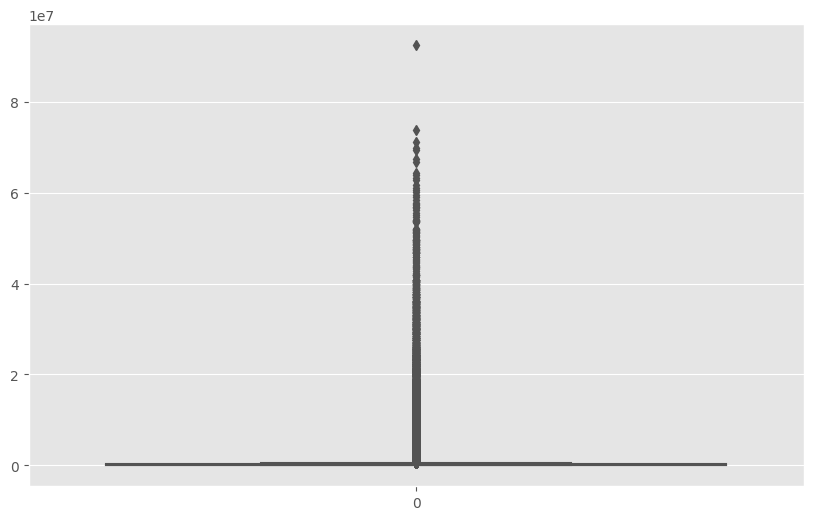

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(df_sample['amount'])

Statistical Analysis

In [ ]:
from scipy import stats
print(stats.mode(df_sample['amount']))
print(np.mean(df_sample['amount']))

ModeResult(mode=10000000.0, count=3207)
179861.90354913071


In [ ]:
q1 = np.quantile(df_sample['amount'], 0.25)
q3 = np.quantile(df_sample['amount'], 0.75)

IQR = q3-q1

upper_bound = q3 + (1.5 * IQR)
lower_bound = q1 - (1.5 * IQR)

print('q1: ', q1)
print('q3: ', q3)
print('IQR: ', IQR)
print('Upper Bound: ', upper_bound)
print('Lower Bound: ', lower_bound)
print('Skewed data: ', len(df_sample[df_sample['amount']>upper_bound]))
print('skewed data: ', len(df_sample[df_sample['amount']<lower_bound]))

q1:  13389.57
q3:  208721.4775
IQR:  195331.9075
Upper Bound:  501719.33875
Lower Bound:  -279608.29125
Skewed data:  338078
skewed data:  0


Data Transformation

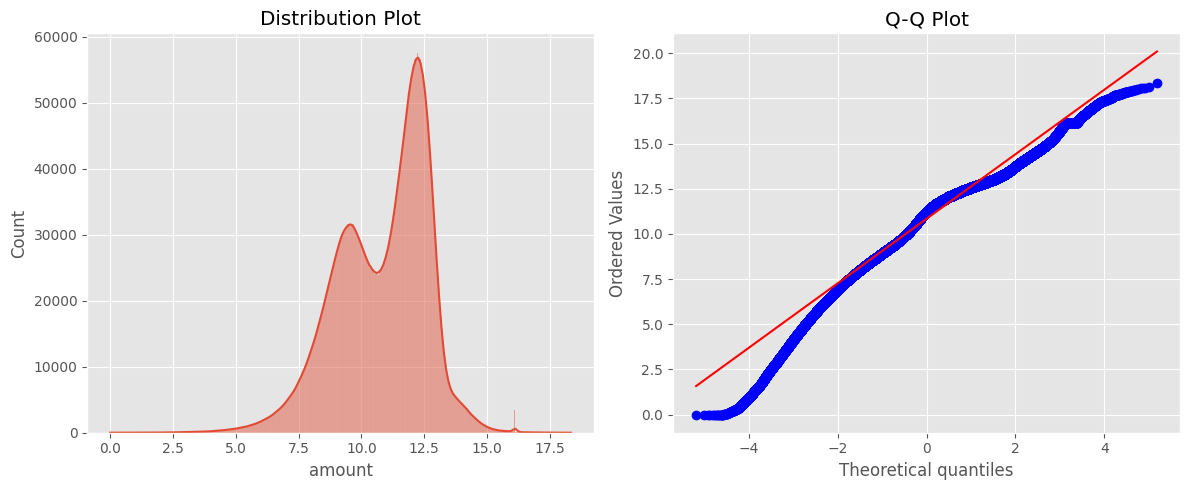

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def transformationPlot(feature):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(feature, kde=True)
    plt.title("Distribution Plot")

    plt.subplot(1, 2, 2)
    stats.probplot(feature, dist="norm", plot=plt)
    plt.title("Q-Q Plot")

    plt.tight_layout()
    plt.show()

# amount = df_sample['amount'] # This line is no longer needed as amount is already transformed
amount_logged = np.log1p(df_sample['amount'])

transformationPlot(amount_logged)

### **Object Data Label Encoding**

In [ ]:
from sklearn.preprocessing import LabelEncoder
la = LabelEncoder()
df_sample['type'] = la.fit_transform(df_sample['type'])

# Label encoding the 'isFraud' column as well, as it is used as the target variable in modeling
df_sample['isFraud'] = la.fit_transform(df_sample['isFraud'])

In [ ]:
df_sample['type'].value_counts()

type
1    2237500
3    2151495
0    1399284
4     532909
2      41432
Name: count, dtype: int64

In [ ]:
df_sample['isFraud'] = 1 - df_sample['isFraud']  # Fixing 0 and 1 reversal

x = df_sample.drop(['isFraud', 'nameOrig', 'nameDest'], axis = 1)
y = df_sample['isFraud']

x

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,nameOrig_count,nameDest_count,nameOrig_mean_amount,nameDest_mean_amount,nameOrig_max_amount,nameDest_max_amount,nameOrig_std_amount,nameDest_std_amount
3737323,278,0,330218.42,20866.00,351084.42,452419.57,122201.15,1,4,330218.42,223913.462500,330218.42,330218.42,0.0,113896.646920
264914,15,3,11647.08,30370.00,18722.92,0.00,0.00,1,1,11647.08,11647.080000,11647.08,11647.08,0.0,0.000000
85647,10,0,152264.21,106589.00,258853.21,201303.01,49038.80,1,25,152264.21,293837.074800,152264.21,1096058.83,0.0,255477.382648
5899326,403,4,1551760.63,0.00,0.00,3198359.45,4750120.08,1,16,1551760.63,540519.046250,1551760.63,2956846.75,0.0,811307.593649
2544263,206,0,78172.30,2921331.58,2999503.88,415821.90,337649.60,1,6,78172.30,207655.765000,78172.30,361898.31,0.0,123749.721601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1570006,155,0,129715.85,5054252.83,5183968.68,246692.94,116977.09,1,12,129715.85,142519.640833,129715.85,418325.36,0.0,113062.544192
2234489,186,3,2459.70,0.00,0.00,0.00,0.00,1,1,2459.70,2459.700000,2459.70,2459.70,0.0,0.000000
4926484,350,1,10579.16,59279.00,48699.84,322754.16,333333.32,1,4,10579.16,110483.465000,10579.16,206128.07,0.0,99592.892080
4304572,307,1,73020.76,20289.00,0.00,256102.84,329123.61,1,8,73020.76,143906.827500,73020.76,305187.15,0.0,100553.441163


In [ ]:
y

3737323    0
264914     0
85647      0
5899326    0
2544263    0
          ..
1570006    0
2234489    0
4926484    0
4304572    0
1692743    0
Name: isFraud, Length: 6362620, dtype: int64

### **Splitting Data into Train & Test**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.2, stratify=y)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(5090096, 15)
(1272524, 15)
(5090096,)
(1272524,)


In [ ]:
# Drop 'nameOrig' and 'nameDest' as they are not used directly in the model
x = df_sample.drop(['isFraud', 'nameOrig', 'nameDest'], axis = 1)
y = df_sample['isFraud']

display(x)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,nameOrig_count,nameDest_count,nameOrig_mean_amount,nameDest_mean_amount,nameOrig_max_amount,nameDest_max_amount,nameOrig_std_amount,nameDest_std_amount
3737323,278,0,330218.42,20866.00,351084.42,452419.57,122201.15,1,4,330218.42,223913.462500,330218.42,330218.42,0.0,113896.646920
264914,15,3,11647.08,30370.00,18722.92,0.00,0.00,1,1,11647.08,11647.080000,11647.08,11647.08,0.0,0.000000
85647,10,0,152264.21,106589.00,258853.21,201303.01,49038.80,1,25,152264.21,293837.074800,152264.21,1096058.83,0.0,255477.382648
5899326,403,4,1551760.63,0.00,0.00,3198359.45,4750120.08,1,16,1551760.63,540519.046250,1551760.63,2956846.75,0.0,811307.593649
2544263,206,0,78172.30,2921331.58,2999503.88,415821.90,337649.60,1,6,78172.30,207655.765000,78172.30,361898.31,0.0,123749.721601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1570006,155,0,129715.85,5054252.83,5183968.68,246692.94,116977.09,1,12,129715.85,142519.640833,129715.85,418325.36,0.0,113062.544192
2234489,186,3,2459.70,0.00,0.00,0.00,0.00,1,1,2459.70,2459.700000,2459.70,2459.70,0.0,0.000000
4926484,350,1,10579.16,59279.00,48699.84,322754.16,333333.32,1,4,10579.16,110483.465000,10579.16,206128.07,0.0,99592.892080
4304572,307,1,73020.76,20289.00,0.00,256102.84,329123.61,1,8,73020.76,143906.827500,73020.76,305187.15,0.0,100553.441163


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.2, stratify=y)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(5090096, 15)
(1272524, 15)
(5090096,)
(1272524,)


## **Model Building**

### **Random Forest Classifier**

In [ ]:
rfc = RandomForestClassifier(n_estimators= 80, n_jobs=-1)
rfc.fit(x_train, y_train)

print('Random Forest Classifier Model Training Complete')

Random Forest Classifier Model Training Complete


In [ ]:
y_train_predict1 = rfc.predict(x_train)
train_accuracy = accuracy_score(y_train, y_train_predict1)
print(f'Random Forest Train Accuracy: {train_accuracy}')

Random Forest Train Accuracy: 0.9999998035400511


In [ ]:
y_test_predict1 = rfc.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_predict1)
print(f'Random Forest Test Accuracy: {test_accuracy}')

Random Forest Test Accuracy: 0.9996872357613688


In [ ]:
pd.crosstab(y_test, y_test_predict1)

col_0,0,1
isFraud,,
0,1270866,15
1,383,1260


In [ ]:
print("Random Forest Classification Report:")
print(classification_report(y_test, y_test_predict1))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.99      0.77      0.86      1643

    accuracy                           1.00   1272524
   macro avg       0.99      0.88      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524



### **Decision Tree Classifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)

print('Decision Tree Classifier Model Training Complete')

y_test_predict2 = dtc.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_predict2)
print(f'Decision Tree Test Accuracy: {test_accuracy}')

Decision Tree Classifier Model Training Complete
Decision Tree Test Accuracy: 0.9996715189654576


In [ ]:
y_train_predict2 = dtc.predict(x_train)
train_accuracy = accuracy_score(y_train, y_train_predict2)
print(f'Decision Tree Train Accuracy: {train_accuracy}')

Decision Tree Train Accuracy: 1.0


In [ ]:
pd.crosstab(y_test, y_test_predict2)

col_0,0,1
isFraud,,
0,1270690,191
1,227,1416


In [ ]:
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_test_predict2))

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.88      0.86      0.87      1643

    accuracy                           1.00   1272524
   macro avg       0.94      0.93      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524



### **ExtraTrees Classifier**

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier(n_estimators=80, n_jobs=-1)
etc.fit(x_train, y_train)

print('Extra Trees Classifier Model Training Complete')

y_test_predict3 = etc.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_predict3)
print(f'Extra Trees Test Accuracy: {test_accuracy}')

Extra Trees Classifier Model Training Complete
Extra Trees Test Accuracy: 0.9995764323501953


In [ ]:
y_train_predict3 = etc.predict(x_train)
train_accuracy = accuracy_score(y_train, y_train_predict3)
print(f'Extra Trees Train Accuracy: {train_accuracy}')

Extra Trees Train Accuracy: 1.0


In [ ]:
pd.crosstab(y_test, y_test_predict3)

col_0,0,1
isFraud,,
0,1270875,6
1,533,1110


In [ ]:
print("Extra Trees Classification Report:")
print(classification_report(y_test, y_test_predict3))

Extra Trees Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.99      0.68      0.80      1643

    accuracy                           1.00   1272524
   macro avg       1.00      0.84      0.90   1272524
weighted avg       1.00      1.00      1.00   1272524



### **SupportVectorMachine (SVC) Classifier**

In [ ]:
# Sample a portion of the data for training SVC
x_train_sample, _, y_train_sample, _ = train_test_split(x_train, y_train, train_size=0.1, random_state=42, stratify=y_train)

from sklearn.svm import SVC
svc = SVC()
svc.fit(x_train_sample, y_train_sample)

print('Support Vector Machine Classifier Model Training Complete')

y_test_predict4=svc.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_predict4)
print(f'Support Vector Machine Test Accuracy: {test_accuracy}')

Support Vector Machine Classifier Model Training Complete
Support Vector Machine Test Accuracy: 0.9990491338473774


In [ ]:
y_train_predict4 = svc.predict(x_train)
train_accuracy = accuracy_score(y_train, y_train_predict4)
print(f'Support Vector Machine Train Accuracy: {train_accuracy}')

Support Vector Machine Train Accuracy: 0.9990786028397107


In [ ]:
pd.crosstab(y_test, y_test_predict4)

col_0,0,1
isFraud,,
0,1270876,5
1,1205,438


In [ ]:
from sklearn.metrics import classification_report
print("Support Vector Machine Classification Report:")
print(classification_report(y_test, y_test_predict4))

Support Vector Machine Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.99      0.27      0.42      1643

    accuracy                           1.00   1272524
   macro avg       0.99      0.63      0.71   1272524
weighted avg       1.00      1.00      1.00   1272524



In [ ]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'nameOrig_count', 'nameDest_count', 'nameOrig_mean_amount',
       'nameDest_mean_amount', 'nameOrig_max_amount', 'nameDest_max_amount',
       'nameOrig_std_amount', 'nameDest_std_amount'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import LabelEncoder

la = LabelEncoder()
# Assuming y_train and y_test are already in numerical format (0 and 1)
# If not, uncomment the lines below
# y_train1= la.fit_transform(y_train)
# y_test1 = la.fit_transform(y_test)

y_train1 = y_train
y_test1 = y_test

print("y_test1 after potential transformation:")
print(y_test1)

y_test1 after potential transformation:
2098218    0
4776589    0
5845695    0
4365572    0
876249     0
          ..
6348834    0
728533     0
4428989    0
155606     0
459366     0
Name: isFraud, Length: 1272524, dtype: int64


In [ ]:
y_train1

3726561    0
1814948    0
6100285    0
3281183    0
2376840    0
          ..
415133     0
817688     0
3006606    0
3518455    0
2512070    0
Name: isFraud, Length: 5090096, dtype: int64

### **XGBoost Classifier**

In [ ]:
import xgboost as xgb
xgb1 = xgb.XGBClassifier()
xgb1.fit(x_train, y_train1)

print('XGBoost Classifier Model Training Complete')

y_test_predict5 = xgb1.predict(x_test)
test_accuracy = accuracy_score(y_test1, y_test_predict5)
print(f'XGBoost Test Accuracy: {test_accuracy}')

XGBoost Classifier Model Training Complete
XGBoost Test Accuracy: 0.9997508887848088


In [ ]:
y_train_predict5 = xgb1.predict(x_train)
train_accuracy = accuracy_score(y_train1, y_train_predict5)
print(f'XGBoost Train Accuracy: {train_accuracy}')

XGBoost Train Accuracy: 0.99987446209266


In [ ]:
pd.crosstab(y_test1, y_test_predict5)

col_0,0,1
isFraud,,
0,1270803,78
1,239,1404


In [ ]:
from sklearn.metrics import classification_report
print("XGBoost Classification Report:")
print(classification_report(y_test1, y_test_predict5))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.95      0.85      0.90      1643

    accuracy                           1.00   1272524
   macro avg       0.97      0.93      0.95   1272524
weighted avg       1.00      1.00      1.00   1272524



### **Model Comparison**

In [ ]:
def compareModel():
    print("train accuracy for rfc", accuracy_score(y_train_predict1, y_train))
    print("test accuracy for rfc", accuracy_score(y_test_predict1, y_test))
    print("train accuracy for dtc", accuracy_score(y_train_predict2, y_train))
    print("test accuracy for dtc", accuracy_score(y_test_predict2, y_test))
    print("train accuracy for etc", accuracy_score(y_train_predict3, y_train))
    print("test accuracy for etc", accuracy_score(y_test_predict3, y_test))
    print("train accuracy for svcc", accuracy_score(y_train_predict4, y_train))
    print("test accuracy for svcc", accuracy_score(y_test_predict4, y_test))
    print("train accuracy for xgb1", accuracy_score(y_train_predict5, y_train1))
    print("test accuracy for xgb1", accuracy_score(y_test_predict5, y_test1))

compareModel()

train accuracy for rfc 0.9999998035400511
test accuracy for rfc 0.9996872357613688
train accuracy for dtc 1.0
test accuracy for dtc 0.9996715189654576
train accuracy for etc 1.0
test accuracy for etc 0.9995764323501953
train accuracy for svcc 0.9990786028397107
test accuracy for svcc 0.9990491338473774
train accuracy for xgb1 0.99987446209266
test accuracy for xgb1 0.9997508887848088


Best Model

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

xgb1 = xgb.XGBClassifier()
xgb1.fit(x_train, y_train1)

y_test_predict5 = xgb1.predict(x_test)
test_accuracy = accuracy_score(y_test1, y_test_predict5)
print(f'XGBoost Test Accuracy: {test_accuracy}')

y_train_predict5 = xgb1.predict(x_train)
train_accuracy = accuracy_score(y_train1, y_train_predict5)
print(f'XGBoost Train Accuracy: {train_accuracy}')

XGBoost Test Accuracy: 0.9997508887848088
XGBoost Train Accuracy: 0.99987446209266


### **Model Saving**

In [ ]:
import pickle
pickle.dump(svc, open('payments.pkl', 'wb'))